In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import pickle
import warnings
warnings.filterwarnings('ignore')

print(" Bibliothèques importées avec succès!")

 Bibliothèques importées avec succès!


In [2]:
# Télécharger le dataset depuis Kaggle 
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

# Noms des colonnes
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Chargement des données
df = pd.read_csv(url, names=column_names)

print(" Données chargées avec succès!")
print(f"\n Dimensions du dataset: {df.shape}")
print("\n Aperçu des premières lignes:")
print(df.head())

 Données chargées avec succès!

 Dimensions du dataset: (768, 9)

 Aperçu des premières lignes:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [26]:

pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pd.set_option('display.width', 200)         # Largeur d'affichage suffisante

#Exploration des données
print(" ANALYSE EXPLORATOIRE DES DONNÉES")

# Informations générales
print("\n Informations générales:")
print(df.info())

# Statistiques descriptives
print("\n Statistiques descriptives:")
print(df.describe())

# Valeurs manquantes
print(80*"_")
print("\n Valeurs manquantes u:")
print(df.isnull().sum())

# Distribution de la variable cible
print("\n Distribution de la variable cible (Outcome):")
print(df['Outcome'].value_counts())
print(f"\nPourcentage de diabétiques: {df['Outcome'].mean() * 100:.2f}%")

 ANALYSE EXPLORATOIRE DES DONNÉES

 Informations générales:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

 Statistiques descriptives:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin         BMI  DiabetesPedigreeFunction         Age     Outcome
count   768

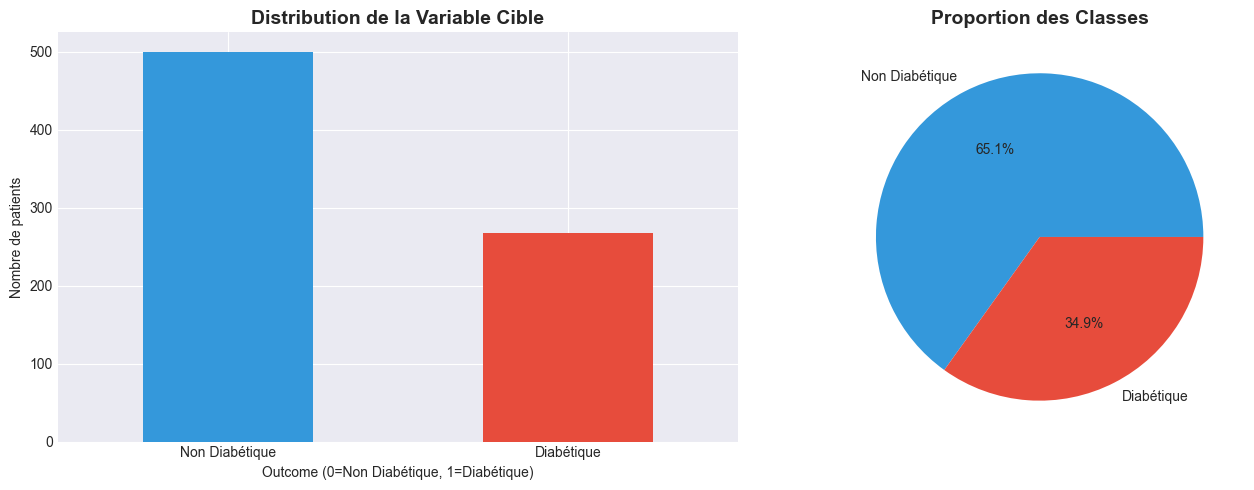

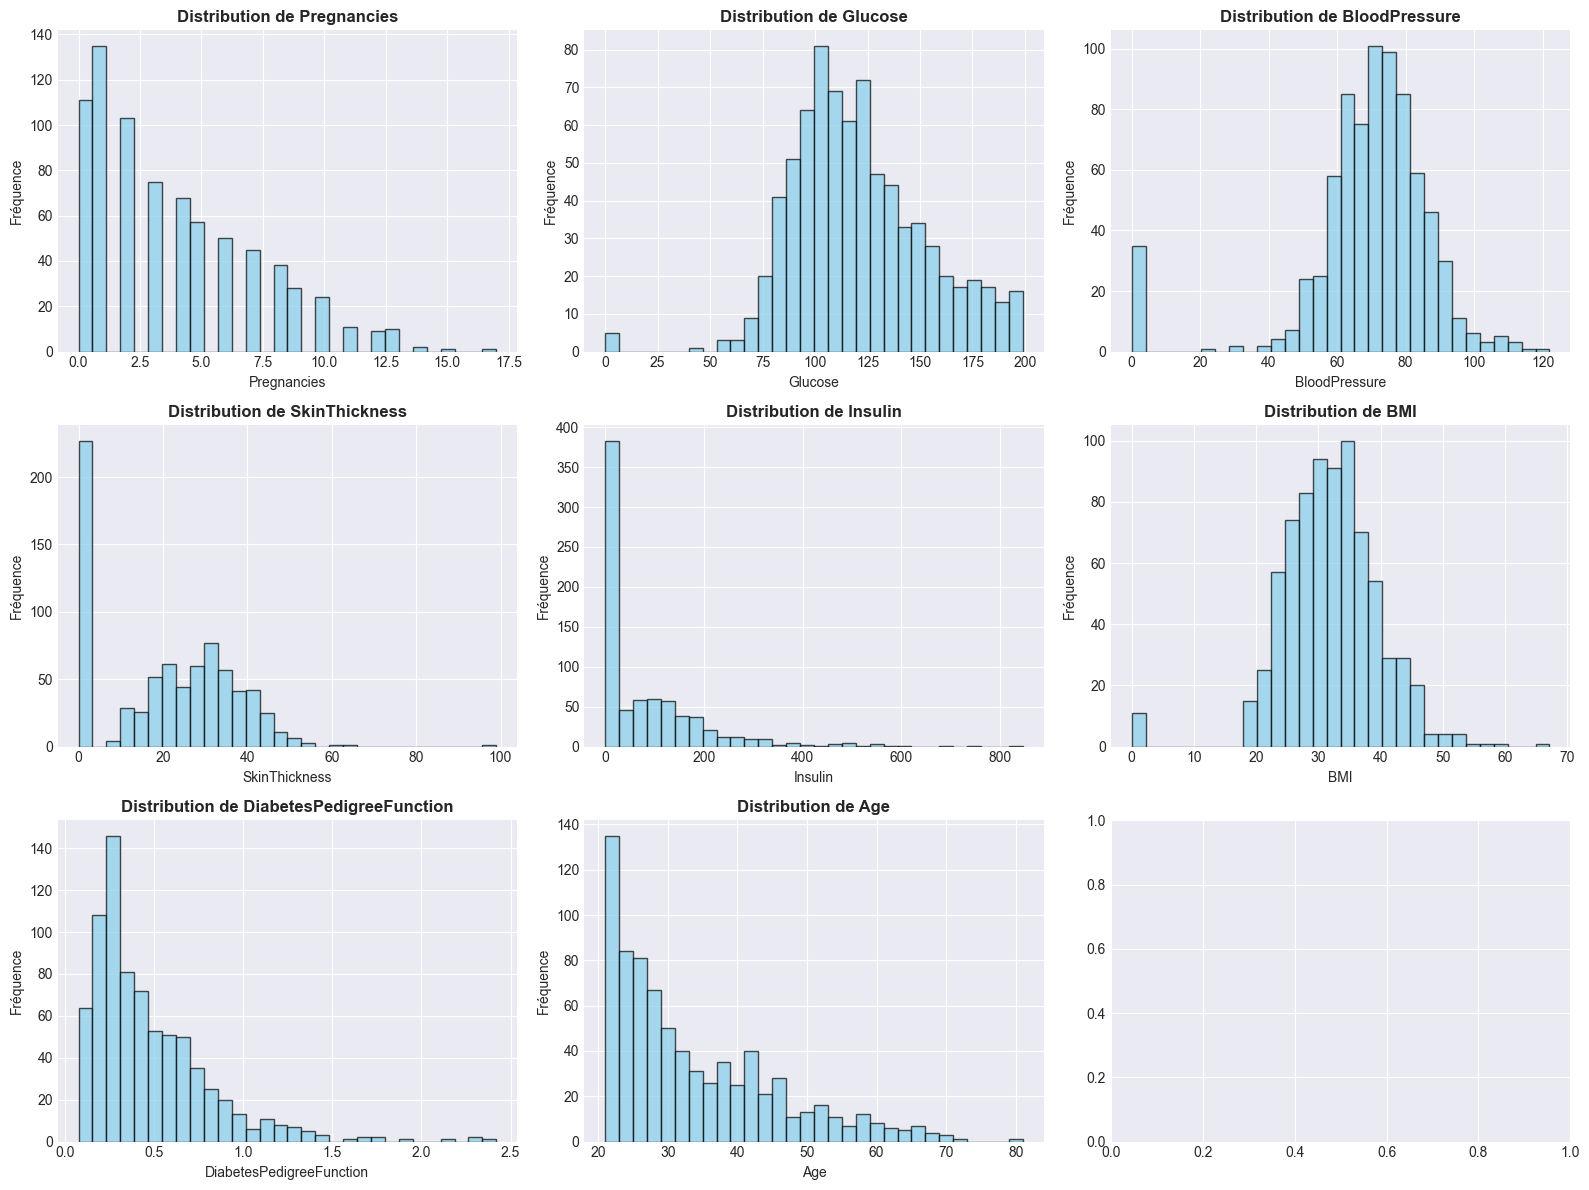

In [27]:
# Visualisation des données
# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Figure 1: Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
df['Outcome'].value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Distribution de la Variable Cible', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Outcome (0=Non Diabétique, 1=Diabétique)')
axes[0].set_ylabel('Nombre de patients')
axes[0].set_xticklabels(['Non Diabétique', 'Diabétique'], rotation=0)

# Pie chart
df['Outcome'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                   labels=['Non Diabétique', 'Diabétique'],
                                   colors=['#3498db', '#e74c3c'])
axes[1].set_title('Proportion des Classes', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Figure 2: Distribution des variables numériques
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(df.columns[:-1]):
    axes[idx].hist(df[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

 DÉTECTION DES VALEURS ABERRANTES

 Nombre de valeurs 0 (biologiquement impossibles):
Glucose: 5 valeurs nulles (0.65%)
BloodPressure: 35 valeurs nulles (4.56%)
SkinThickness: 227 valeurs nulles (29.56%)
Insulin: 374 valeurs nulles (48.70%)
BMI: 11 valeurs nulles (1.43%)


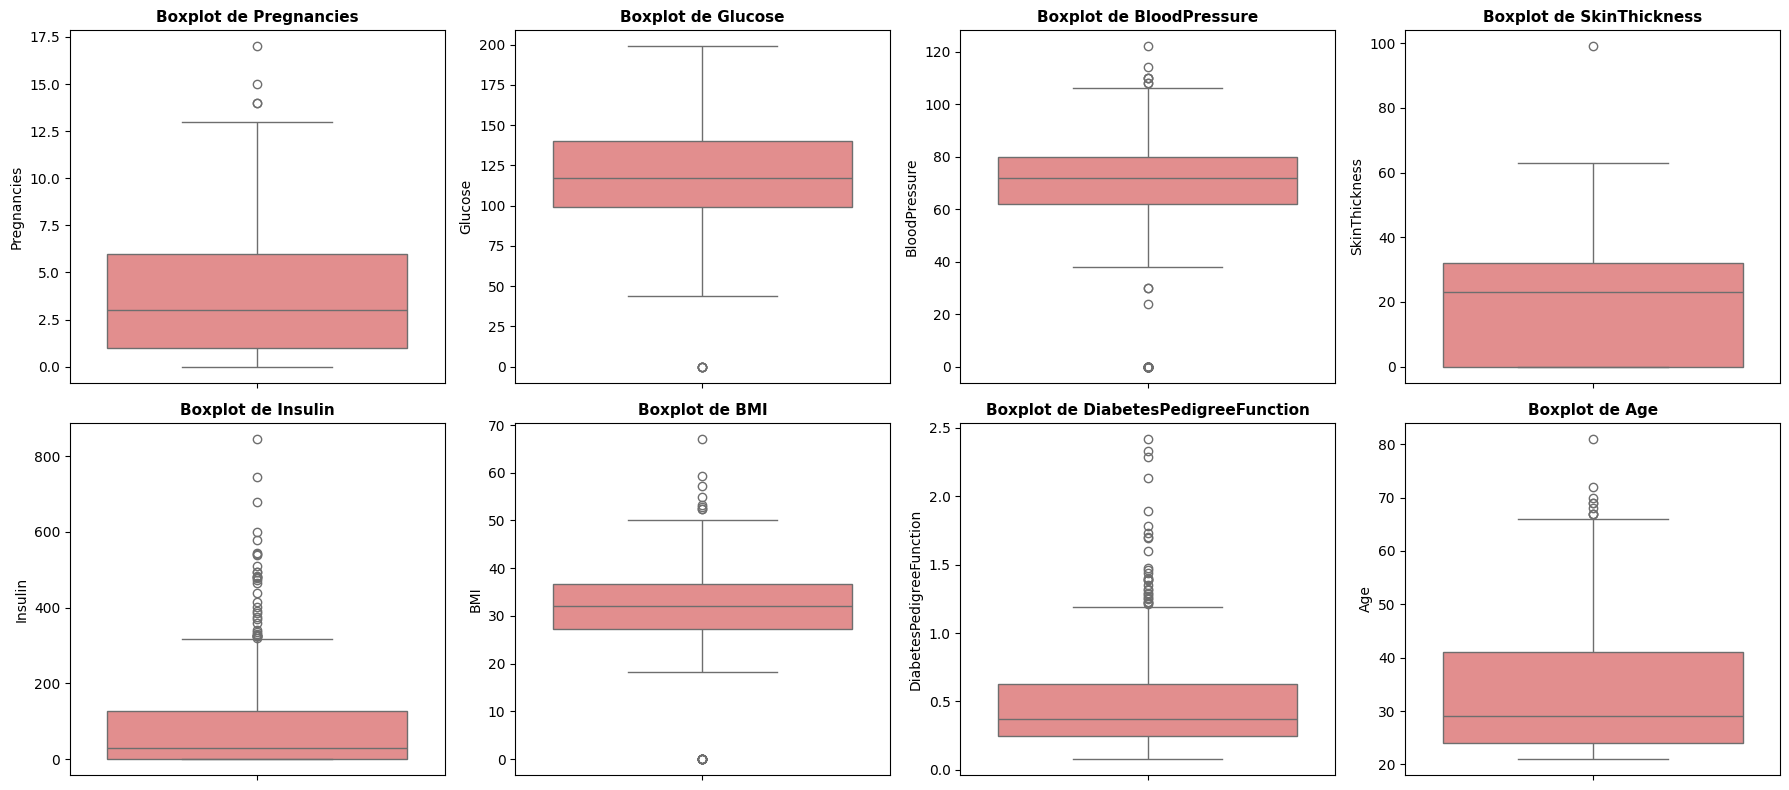

In [4]:
# Détection et traitement des valeurs aberrantes
print(" DÉTECTION DES VALEURS ABERRANTES")

# Certaines colonnes ne peuvent pas avoir de valeurs 0
zero_not_accepted = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("\n Nombre de valeurs 0 (biologiquement impossibles):")
for column in zero_not_accepted:
    count = (df[column] == 0).sum()
    print(f"{column}: {count} valeurs nulles ({count/len(df)*100:.2f}%)")

# Visualisation des boxplots
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.ravel()

for idx, col in enumerate(df.columns[:-1]):
    sns.boxplot(y=df[col], ax=axes[idx], color='lightcoral')
    axes[idx].set_title(f'Boxplot de {col}', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel(col)

plt.tight_layout()
plt.show()

In [5]:
#Préparation des données (Traitement des valeurs manquantes)
print(" PRÉPARATION DES DONNÉES")

# Créer une copie pour le traitement
df_clean = df.copy()

# Remplacer les 0 par NaN pour les colonnes concernées
for column in zero_not_accepted:
    df_clean[column] = df_clean[column].replace(0, np.nan)

print("\n Valeurs manquantes après remplacement des 0:")
print(df_clean.isnull().sum())

# Stratégie: Remplacer par la médiane (plus robuste que la moyenne)
print("\n Remplacement des valeurs manquantes par la médiane...")
for column in zero_not_accepted:
    median_value = df_clean[column].median()
    df_clean[column].fillna(median_value, inplace=True)
    print(f"   - {column}: médiane = {median_value:.2f}")

print("\n Traitement terminé!")
print("\n Vérification finale des valeurs manquantes:")
print(df_clean.isnull().sum())

print(f"\n Dimensions finales: {df_clean.shape}")

 PRÉPARATION DES DONNÉES

 Valeurs manquantes après remplacement des 0:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

 Remplacement des valeurs manquantes par la médiane...
   - Glucose: médiane = 117.00
   - BloodPressure: médiane = 72.00
   - SkinThickness: médiane = 29.00
   - Insulin: médiane = 125.00
   - BMI: médiane = 32.30

 Traitement terminé!

 Vérification finale des valeurs manquantes:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

 Dimensions finales: (768, 9)


 ANALYSE DE CORRÉLATION


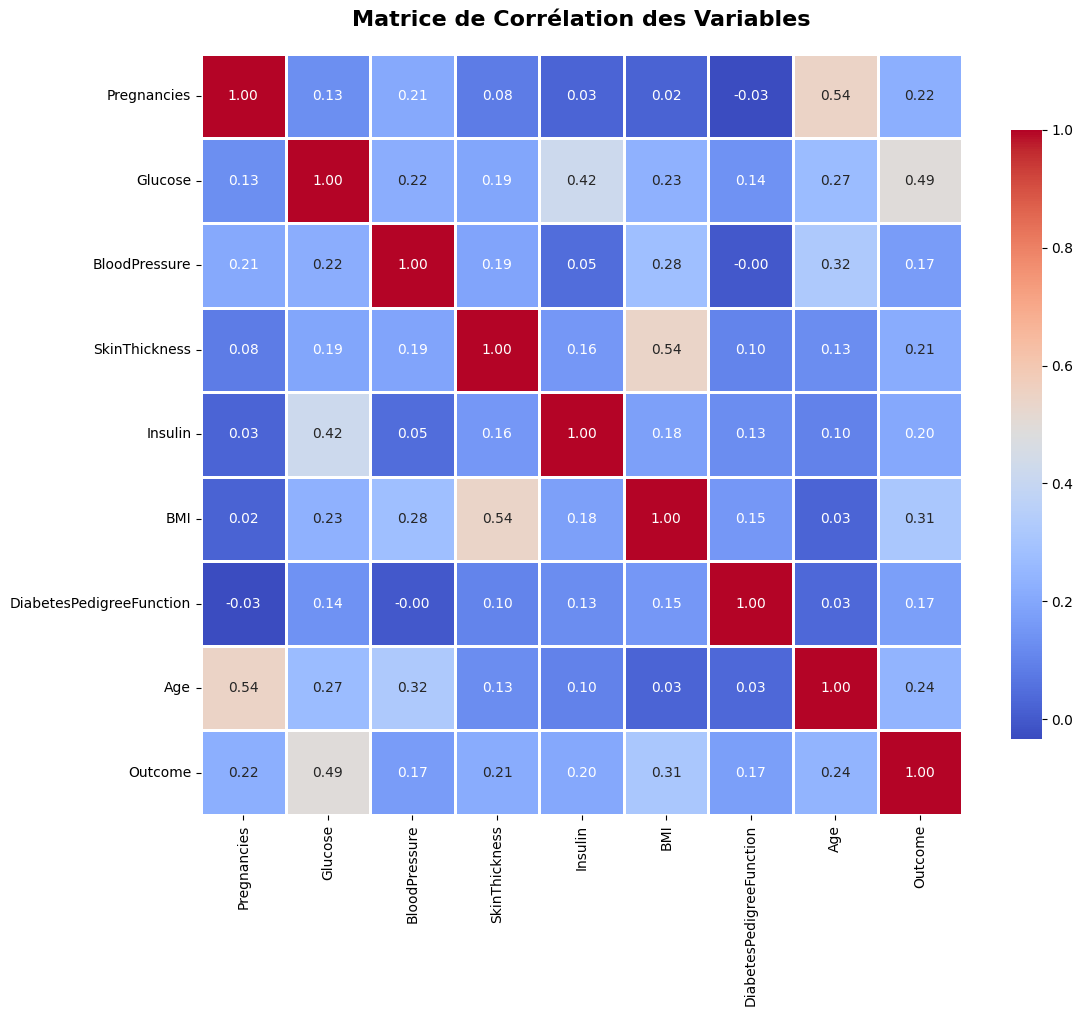


 Corrélation avec la variable cible (Outcome):
Outcome                     1.000000
Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Name: Outcome, dtype: float64


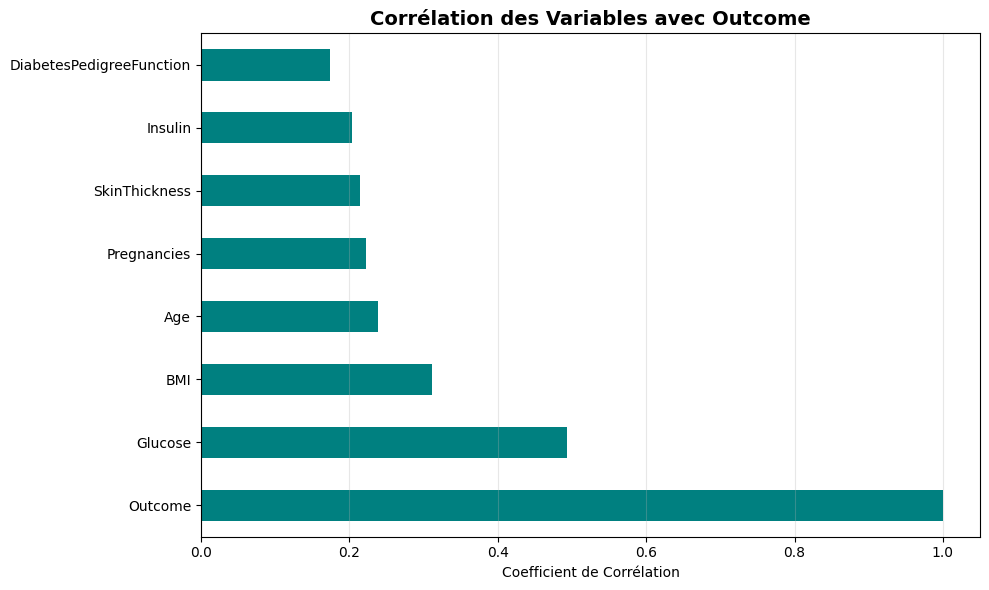

In [6]:

# Analyse de corrélation
print(" ANALYSE DE CORRÉLATION")

# Matrice de corrélation
correlation_matrix = df_clean.corr()

# Visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Corrélation avec la variable cible
print("\n Corrélation avec la variable cible (Outcome):")
target_corr = correlation_matrix['Outcome'].sort_values(ascending=False)
print(target_corr)

# Visualisation des corrélations avec Outcome
plt.figure(figsize=(10, 6))
target_corr[:-1].plot(kind='barh', color='teal')
plt.title('Corrélation des Variables avec Outcome', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient de Corrélation')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

 SÉLECTION DES CARACTÉRISTIQUES

 Caractéristiques les plus corrélées avec Outcome:
Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Name: Outcome, dtype: float64

 Top 5 caractéristiques les plus importantes:
   1. Glucose: 0.4928
   2. BMI: 0.3120
   3. Age: 0.2384
   4. Pregnancies: 0.2219
   5. SkinThickness: 0.2149


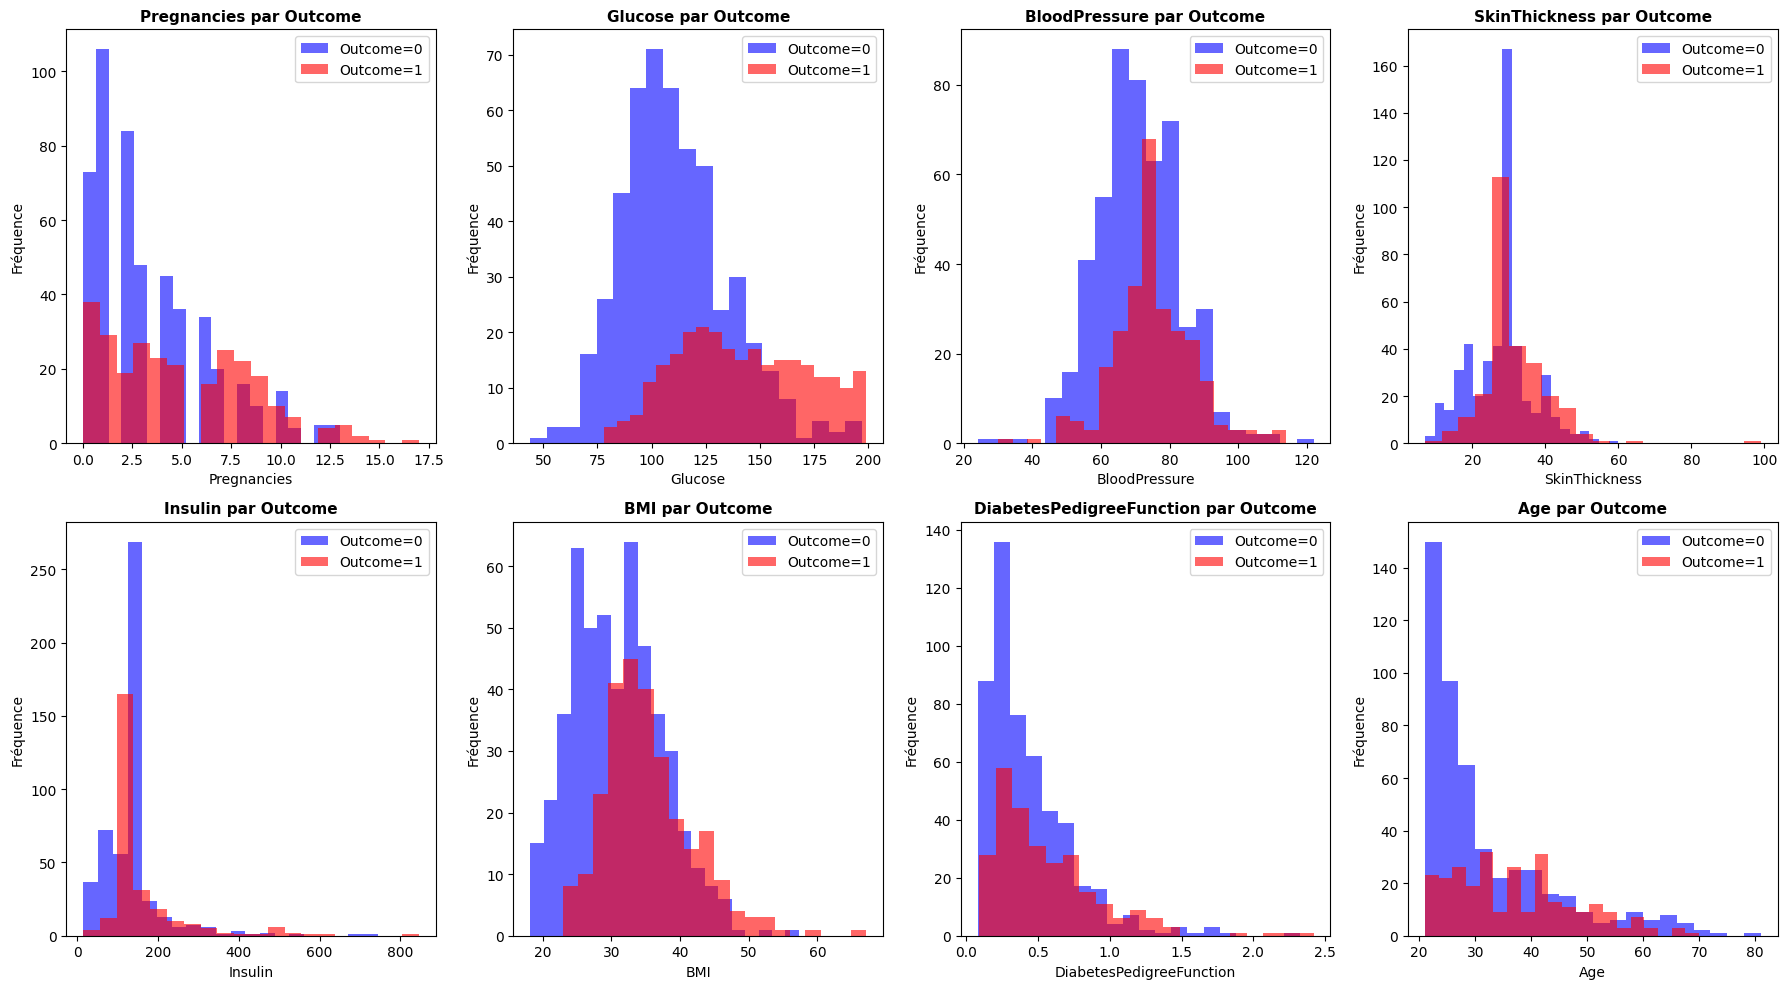

In [7]:
#  Sélection des caractéristiques importantes

print(" SÉLECTION DES CARACTÉRISTIQUES")

# Utiliser toutes les features (car le dataset est déjà petit)
# Mais identifier les plus importantes selon la corrélation

print("\n Caractéristiques les plus corrélées avec Outcome:")
important_features = target_corr[1:].abs().sort_values(ascending=False)
print(important_features)

print("\n Top 5 caractéristiques les plus importantes:")
top_5_features = important_features.head(5)
for i, (feature, corr) in enumerate(top_5_features.items(), 1):
    print(f"   {i}. {feature}: {corr:.4f}")

# Visualisation comparative
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(df_clean.columns[:-1]):
    for outcome in [0, 1]:
        data = df_clean[df_clean['Outcome'] == outcome][col]
        axes[idx].hist(data, bins=20, alpha=0.6, 
                      label=f'Outcome={outcome}', 
                      color='blue' if outcome == 0 else 'red')
    axes[idx].set_title(f'{col} par Outcome', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Fréquence')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [8]:
# Préparation des données pour le ML
print(" PRÉPARATION POUR LE MACHINE LEARNING")

# Séparation des features et de la cible
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

print(f" Features (X): {X.shape}")
print(f" Target (y): {y.shape}")

# Division train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Taille du jeu d'entraînement: {X_train.shape[0]} échantillons")
print(f" Taille du jeu de test: {X_test.shape[0]} échantillons")

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n Standardisation effectuée!")
print(f"   - Moyenne des features après standardisation: {X_train_scaled.mean():.4f}")
print(f"   - Écart-type des features après standardisation: {X_train_scaled.std():.4f}")

 PRÉPARATION POUR LE MACHINE LEARNING
 Features (X): (768, 8)
 Target (y): (768,)

 Taille du jeu d'entraînement: 614 échantillons
 Taille du jeu de test: 154 échantillons

 Standardisation effectuée!
   - Moyenne des features après standardisation: -0.0000
   - Écart-type des features après standardisation: 1.0000


In [9]:
# CELLULE 10: Entraînement et comparaison de plusieurs modèles

print(" ENTRAÎNEMENT ET COMPARAISON DES MODÈLES")

# Dictionnaire des modèles à tester
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Dictionnaire pour stocker les résultats
results = {}

print("\n Entraînement en cours...\n")

for name, model in models.items():
    print(f" Entraînement: {name}")
    
    # Entraînement
    model.fit(X_train_scaled, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    # AUC-ROC
    if y_pred_proba is not None:
        auc_roc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc_roc = None
    
    # Stocker les résultats
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'auc_roc': auc_roc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"   ✓ Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f} | CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print()

print(" Tous les modèles ont été entraînés!")

 ENTRAÎNEMENT ET COMPARAISON DES MODÈLES

 Entraînement en cours...

 Entraînement: Logistic Regression
   ✓ Accuracy: 0.7078 | F1-Score: 0.5455 | CV: 0.7818 ± 0.0125

 Entraînement: Decision Tree
   ✓ Accuracy: 0.6818 | F1-Score: 0.5149 | CV: 0.6873 ± 0.0156

 Entraînement: Random Forest
   ✓ Accuracy: 0.7792 | F1-Score: 0.6600 | CV: 0.7688 ± 0.0337

 Entraînement: Gradient Boosting
   ✓ Accuracy: 0.7597 | F1-Score: 0.6263 | CV: 0.7622 ± 0.0313

 Entraînement: SVM
   ✓ Accuracy: 0.7403 | F1-Score: 0.6000 | CV: 0.7688 ± 0.0179

 Entraînement: K-Nearest Neighbors
   ✓ Accuracy: 0.7532 | F1-Score: 0.6346 | CV: 0.7444 ± 0.0297

 Entraînement: Naive Bayes
   ✓ Accuracy: 0.7013 | F1-Score: 0.5965 | CV: 0.7590 ± 0.0077

 Tous les modèles ont été entraînés!


In [11]:
#Tableau comparatif des performances

print(" TABLEAU COMPARATIF DES PERFORMANCES")

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()],
    'AUC-ROC': [results[m]['auc_roc'] if results[m]['auc_roc'] else 0 for m in results.keys()]
})

# Trier par F1-Score
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)
results_df.index = results_df.index + 1

print("\n")
print(results_df.to_string())

# Identifier le meilleur modèle
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print("\n" + "=" * 80)
print(f" MEILLEUR MODÈLE: {best_model_name}")
print(f"    Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"    F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"    AUC-ROC: {results_df.iloc[0]['AUC-ROC']:.4f}")


 TABLEAU COMPARATIF DES PERFORMANCES


                 Model  Accuracy  Precision    Recall  F1-Score   CV Mean    CV Std   AUC-ROC
1        Random Forest  0.779221   0.717391  0.611111  0.660000  0.768772  0.033686  0.817870
2  K-Nearest Neighbors  0.753247   0.660000  0.611111  0.634615  0.744382  0.029674  0.788611
3    Gradient Boosting  0.759740   0.688889  0.574074  0.626263  0.762228  0.031339  0.830370
4                  SVM  0.740260   0.652174  0.555556  0.600000  0.768759  0.017891  0.796389
5          Naive Bayes  0.701299   0.566667  0.629630  0.596491  0.758976  0.007719  0.764630
6  Logistic Regression  0.707792   0.600000  0.500000  0.545455  0.781794  0.012452  0.812963
7        Decision Tree  0.681818   0.553191  0.481481  0.514851  0.687312  0.015607  0.635741

 MEILLEUR MODÈLE: Random Forest
    Accuracy: 0.7792
    F1-Score: 0.6600
    AUC-ROC: 0.8179


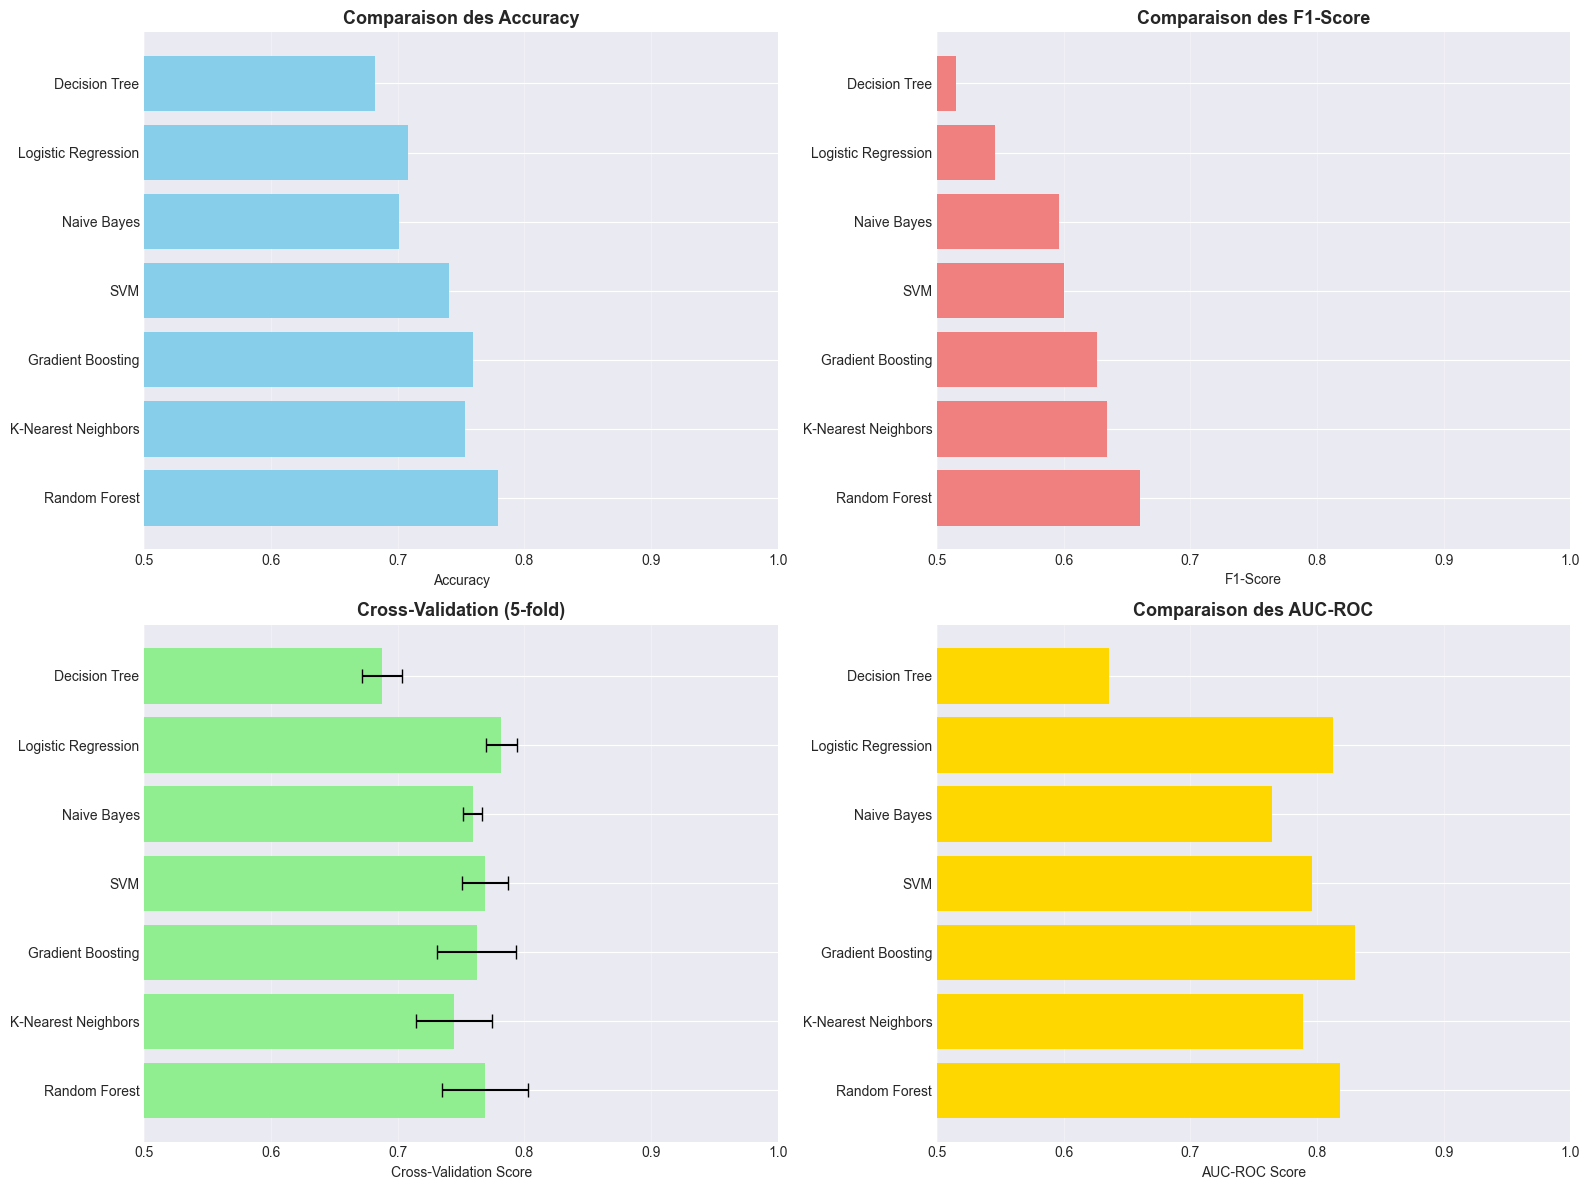

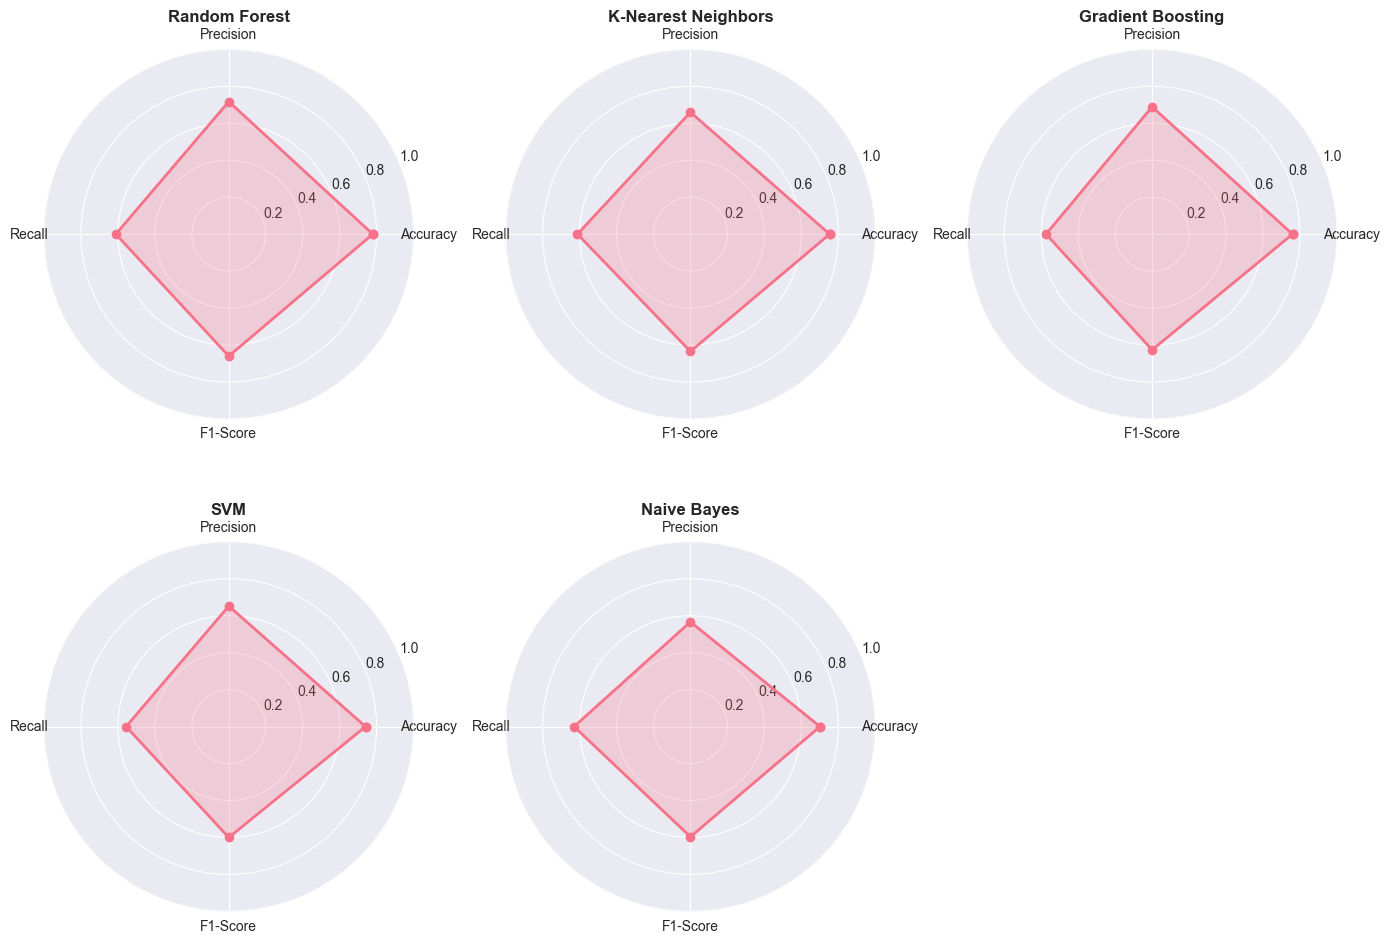

In [14]:
# Visualisation des performances

# Graphique comparatif des métriques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy
axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Comparaison des Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].set_xlim([0.5, 1])
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. F1-Score
axes[0, 1].barh(results_df['Model'], results_df['F1-Score'], color='lightcoral')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Comparaison des F1-Score', fontsize=13, fontweight='bold')
axes[0, 1].set_xlim([0.5, 1])
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Cross-Validation Scores
cv_data = results_df[['Model', 'CV Mean', 'CV Std']]
axes[1, 0].barh(cv_data['Model'], cv_data['CV Mean'], xerr=cv_data['CV Std'], 
                color='lightgreen', capsize=5)
axes[1, 0].set_xlabel('Cross-Validation Score')
axes[1, 0].set_title('Cross-Validation (5-fold)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlim([0.5, 1])
axes[1, 0].grid(axis='x', alpha=0.3)
# 4. AUC-ROC
auc_data = results_df[results_df['AUC-ROC'] > 0]
axes[1, 1].barh(auc_data['Model'], auc_data['AUC-ROC'], color='gold')
axes[1, 1].set_xlabel('AUC-ROC Score')
axes[1, 1].set_title('Comparaison des AUC-ROC', fontsize=13, fontweight='bold')
axes[1, 1].set_xlim([0.5, 1])
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Graphique radar
from math import pi

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig = plt.figure(figsize=(14, 10))
for idx, model_name in enumerate(results_df.head(5)['Model']):
    values = [
        results[model_name]['accuracy'],
        results[model_name]['precision'],
        results[model_name]['recall'],
        results[model_name]['f1_score']
    ]
    values += values[:1]  # Fermer le polygone
    
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]
    
    ax = plt.subplot(2, 3, idx + 1, projection='polar')
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.set_title(model_name, fontsize=12, fontweight='bold', pad=20)
    ax.grid(True)

plt.tight_layout()
plt.show()

 ANALYSE DÉTAILLÉE DU MEILLEUR MODÈLE: Random Forest


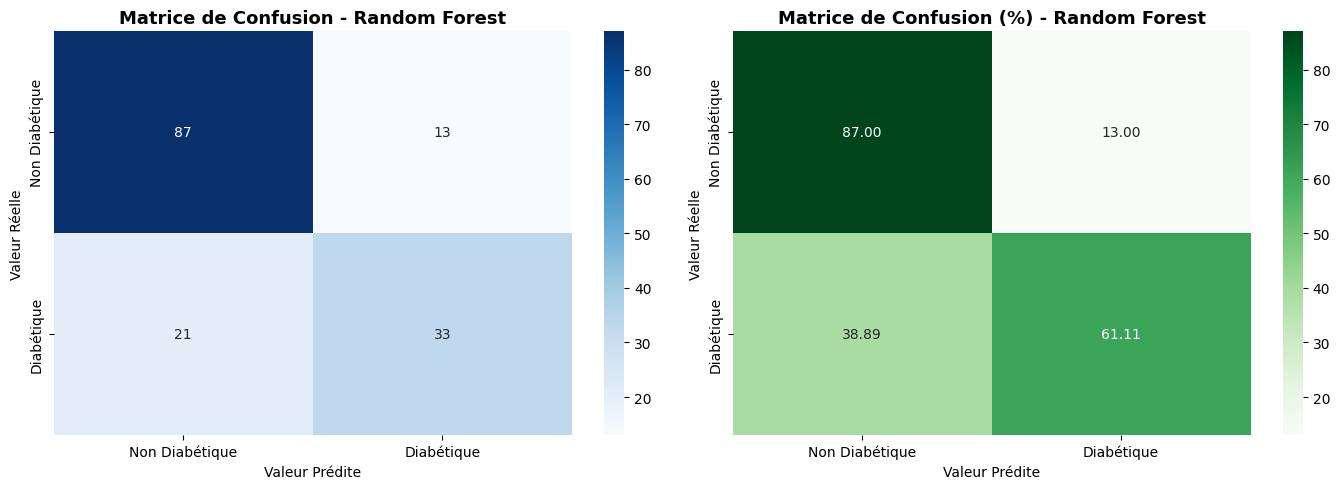


 Rapport de Classification:
                precision    recall  f1-score   support

Non Diabétique       0.81      0.87      0.84       100
    Diabétique       0.72      0.61      0.66        54

      accuracy                           0.78       154
     macro avg       0.76      0.74      0.75       154
  weighted avg       0.77      0.78      0.77       154



In [12]:

# CELLULE 13: Matrice de confusion du meilleur modèle
print(f" ANALYSE DÉTAILLÉE DU MEILLEUR MODÈLE: {best_model_name}")

# Prédictions du meilleur modèle
y_pred_best = results[best_model_name]['y_pred']

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_best)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice de confusion (nombres)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Non Diabétique', 'Diabétique'],
            yticklabels=['Non Diabétique', 'Diabétique'])
axes[0].set_title(f'Matrice de Confusion - {best_model_name}', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Valeur Réelle')
axes[0].set_xlabel('Valeur Prédite')

# Matrice de confusion (pourcentages)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Greens', ax=axes[1],
            xticklabels=['Non Diabétique', 'Diabétique'],
            yticklabels=['Non Diabétique', 'Diabétique'])
axes[1].set_title(f'Matrice de Confusion (%) - {best_model_name}', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Valeur Réelle')
axes[1].set_xlabel('Valeur Prédite')

plt.tight_layout()
plt.show()

# Rapport de classification
print("\n Rapport de Classification:")
print(classification_report(y_test, y_pred_best, 
                          target_names=['Non Diabétique', 'Diabétique']))


 COURBES ROC


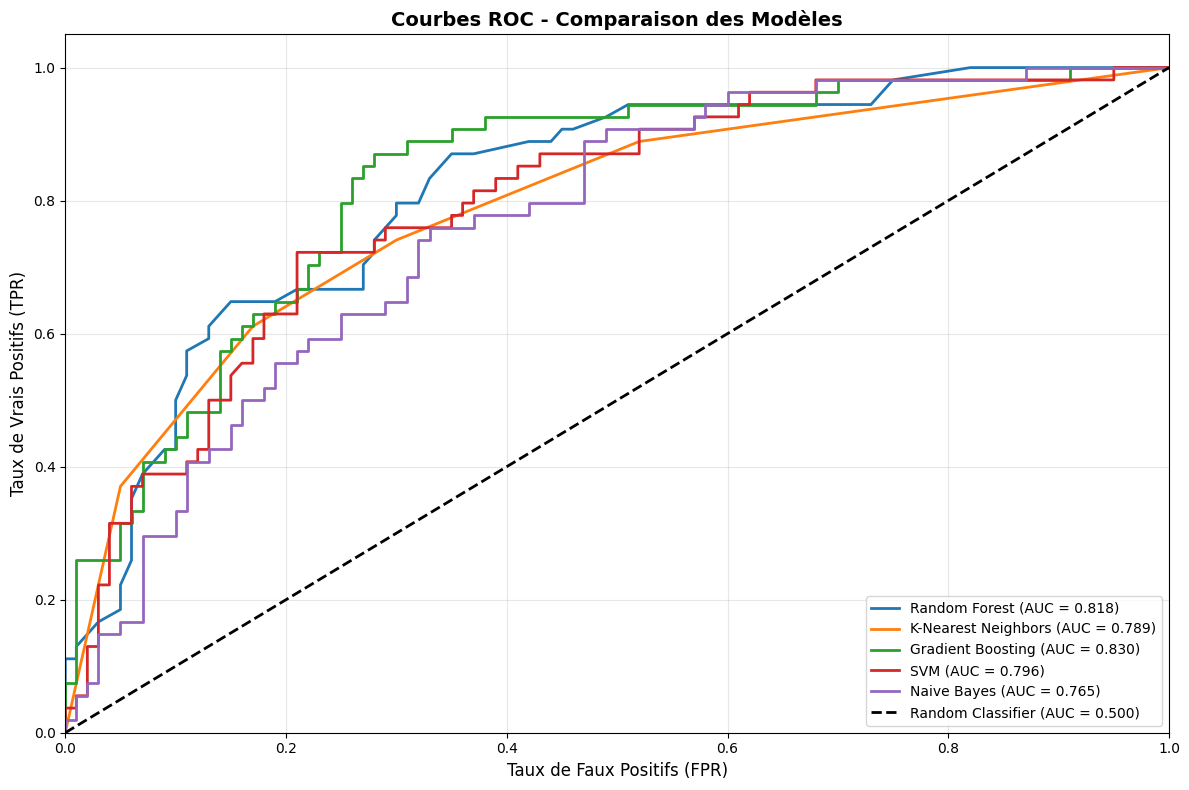

In [13]:
# Courbe ROC
print(" COURBES ROC")

plt.figure(figsize=(12, 8))

for name in results_df.head(5)['Model']:
    if results[name]['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
        auc = results[name]['auc_roc']
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

 IMPORTANCE DES CARACTÉRISTIQUES - Random Forest


                 Feature  Importance
                 Glucose    0.274086
                     BMI    0.161903
DiabetesPedigreeFunction    0.125020
                     Age    0.112985
                 Insulin    0.091224
           BloodPressure    0.083518
             Pregnancies    0.080795
           SkinThickness    0.070468


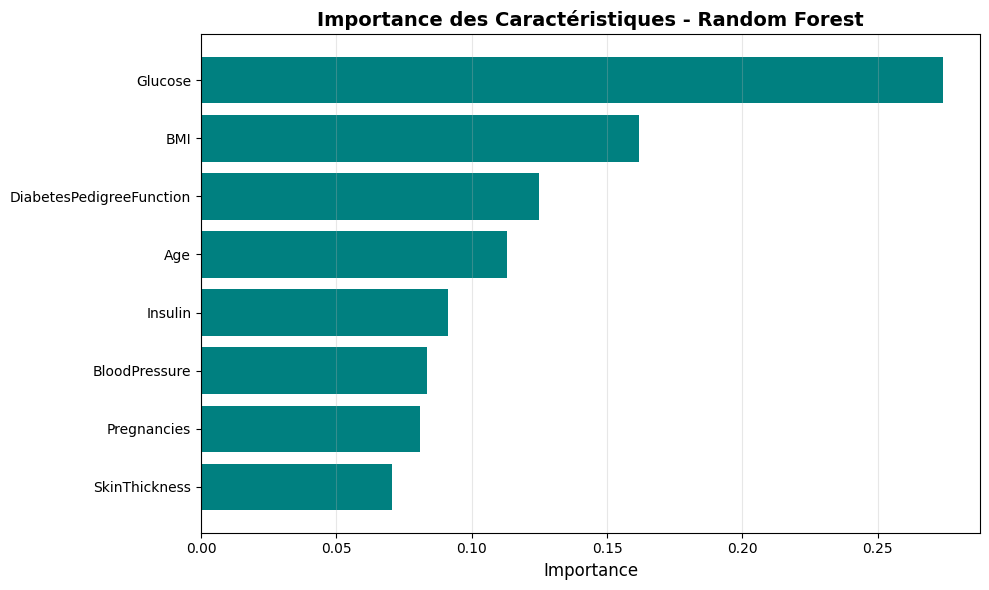

In [14]:
# Feature Importance (pour les modèles basés sur les arbres)

if best_model_name in ['Random Forest', 'Decision Tree', 'Gradient Boosting']:
    print(f" IMPORTANCE DES CARACTÉRISTIQUES - {best_model_name}")
    
    # Récupérer l'importance des features
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n")
    print(feature_importance.to_string(index=False))
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='teal')
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Importance des Caractéristiques - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [15]:
#Sauvegarde du meilleur modèle et du scaler

print(" SAUVEGARDE DU MODÈLE")

# Sauvegarder le modèle
model_filename = 'diabetes_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f" Modèle sauvegardé: {model_filename}")

# Sauvegarder le scaler
scaler_filename = 'diabetes_scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
print(f" Scaler sauvegardé: {scaler_filename}")

# Sauvegarder les noms des features
feature_names = X.columns.tolist()
features_filename = 'feature_names.pkl'
with open(features_filename, 'wb') as file:
    pickle.dump(feature_names, file)
print(f" Noms des features sauvegardés: {features_filename}")

print("\n Tout est prêt pour le déploiement Flask!")
print(f"\n Meilleur modèle: {best_model_name}")
print(f" Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f" F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

 SAUVEGARDE DU MODÈLE
 Modèle sauvegardé: diabetes_model.pkl
 Scaler sauvegardé: diabetes_scaler.pkl
 Noms des features sauvegardés: feature_names.pkl

 Tout est prêt pour le déploiement Flask!

 Meilleur modèle: Random Forest
 Accuracy: 0.7792
 F1-Score: 0.6600


In [16]:
# CELLULE 17: Test de prédiction

print(" TEST DE PRÉDICTION")

# Exemple de prédiction avec un nouveau patient
exemple_patient = np.array([[5, 180, 80, 25, 120, 35.0, 0.45, 30]])
# # Patient typiquement diabétique
# patient1 = np.array([[5, 180, 80, 25, 120, 35.0, 0.45, 50]])

# # Patient typiquement non diabétique
# patient2 = np.array([[1, 90, 70, 20, 80, 22.5, 0.15, 25]])

# Charger les modèles sauvegardés (pour simuler le déploiement)
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

with open(scaler_filename, 'rb') as file:
    loaded_scaler = pickle.load(file)

# Standardiser et prédire
exemple_scaled = loaded_scaler.transform(exemple_patient)
prediction = loaded_model.predict(exemple_scaled)
prediction_proba = loaded_model.predict_proba(exemple_scaled)[0] if hasattr(loaded_model, 'predict_proba') else None

print("\n👤 Données du patient test:")
for i, feature in enumerate(feature_names):
    print(f"   - {feature}: {exemple_patient[0][i]}")

print(f"\n Prédiction: {'DIABÉTIQUE ' if prediction[0] == 1 else 'NON DIABÉTIQUE '}")

if prediction_proba is not None:
    print(f"\n📊 Probabilités:")
    print(f"   - Non Diabétique: {prediction_proba[0]:.2%}")
    print(f"   - Diabétique: {prediction_proba[1]:.2%}")

print("\n Le modèle est prêt à être déployé avec Flask!")

 TEST DE PRÉDICTION

👤 Données du patient test:
   - Pregnancies: 5.0
   - Glucose: 180.0
   - BloodPressure: 80.0
   - SkinThickness: 25.0
   - Insulin: 120.0
   - BMI: 35.0
   - DiabetesPedigreeFunction: 0.45
   - Age: 30.0

 Prédiction: DIABÉTIQUE 

📊 Probabilités:
   - Non Diabétique: 30.00%
   - Diabétique: 70.00%

 Le modèle est prêt à être déployé avec Flask!


In [18]:
import numpy as np
import pickle

# CELLULE 17: Test de prédiction
model_filename = "diabetes_model.pkl"
scaler_filename = "diabetes_scaler.pkl"
feature_names_file = "feature_names.pkl"

print(" TEST DE PRÉDICTION")
print("_" * 80)

# Charger les fichiers sauvegardés
with open(model_filename, "rb") as file:
    loaded_model = pickle.load(file)

with open(scaler_filename, "rb") as file:
    loaded_scaler = pickle.load(file)

with open(feature_names_file, "rb") as file:
    feature_names = pickle.load(file)

# Exemple de prédiction avec un nouveau patient
exemple_patient = np.array([[5, 180, 80, 25, 120, 35.0, 0.45, 30]])

# Standardiser et prédire
exemple_scaled = loaded_scaler.transform(exemple_patient)
prediction = loaded_model.predict(exemple_scaled)
prediction_proba = loaded_model.predict_proba(exemple_scaled)[0] if hasattr(loaded_model, 'predict_proba') else None

# Affichage des résultats
print("\n Données du patient test:")
for i, feature in enumerate(feature_names):
    print(f"   - {feature}: {exemple_patient[0][i]}")

print(f"\n Prédiction: {'DIABÉTIQUE ' if prediction[0] == 1 else 'NON DIABÉTIQUE '}")

if prediction_proba is not None:
    print(f"\n Probabilités:")
    print(f"   - Non Diabétique: {prediction_proba[0]:.2%}")
    print(f"   - Diabétique: {prediction_proba[1]:.2%}")

print("\n Le modèle est prêt à être déployé avec Flask!")


 TEST DE PRÉDICTION
________________________________________________________________________________

 Données du patient test:
   - Pregnancies: 5.0
   - Glucose: 180.0
   - BloodPressure: 80.0
   - SkinThickness: 25.0
   - Insulin: 120.0
   - BMI: 35.0
   - DiabetesPedigreeFunction: 0.45
   - Age: 30.0

 Prédiction: DIABÉTIQUE 

 Probabilités:
   - Non Diabétique: 30.00%
   - Diabétique: 70.00%

 Le modèle est prêt à être déployé avec Flask!
